In [1]:
# mount drive to gain access to data and modules, run once
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/colab_scripts')

Mounted at /content/drive


In [56]:
import pandas as pd
import numpy as np

# import the datasets and extract features into numpy arrays
with pd.HDFStore("/content/drive/MyDrive/colab_data/h5_datasets/synced_48Hz_trim.h5") as data:
  keys = data.keys()
  df_list = []
  for key in keys:
    df_list.append(data.get(key))

In [117]:

def replace_elements(arrays, lower_threshold, upper_threshold, l_value, h_value):
    for i in range(len(arrays)):
        arrays[i] = np.where(arrays[i] < lower_threshold, l_value, arrays[i])
        arrays[i] = np.where(arrays[i] > upper_threshold, h_value, arrays[i])
    return arrays

In [118]:
import data_preprocessing_v3 as dpp

X, Y = dpp.get_scaled_data(df_list)
X = replace_elements(X,-1,1,-1,1)
X, Y = dpp.reshape_for_LSTM(X,Y)
X_uv = get_uv_features(X)

# test = X[0].reshape(X[0].shape[0],1,X[0].shape[1])

In [68]:
# Load in the models
import tensorflow as tf

model_1L = tf.keras.models.load_model("/content/drive/MyDrive/colab_data/trained_models/best_models/1L_best.keras")
model_2L = tf.keras.models.load_model("/content/drive/MyDrive/colab_data/trained_models/best_models/2L_best.keras")
model_1L_uv = tf.keras.models.load_model("/content/drive/MyDrive/colab_data/trained_models/best_models/1L_uv_best.keras")
model_2L_uv = tf.keras.models.load_model("/content/drive/MyDrive/colab_data/trained_models/best_models/2L_uv_best.keras")

In [121]:
# make predictions
predictions_1L = []
predictions_2L = []
predictions_1L_uv = []
predictions_2L_uv = []

for i in range(len(X)):
  print("predicting dataset: " + keys[i] + f" ({i}/61)")
  model_1L.reset_states()
  model_2L.reset_states()
  model_1L_uv.reset_states()
  model_2L_uv.reset_states()
  predictions_1L.append(model_1L.predict(X[i],batch_size=1,verbose=2))
  predictions_2L.append(model_2L.predict(X[i],batch_size=1,verbose=2))
  predictions_1L_uv.append(model_1L_uv.predict(X_uv[i],batch_size=1,verbose=2))
  predictions_2L_uv.append(model_2L_uv.predict(X_uv[i],batch_size=1,verbose=2))

# with pd.HDFStore("/content/drive/MyDrive/colab_data/h5_datasets/predictions_v1.h5") as out:
data = []
for i in range(62):
  df = pd.DataFrame({
      'model_L1': np.squeeze(predictions_1L[i]),
      'model_L2': np.squeeze(predictions_2L[i]),
      'model_L1_uv': np.squeeze(predictions_1L_uv[i]),
      'model_L2_uv': np.squeeze(predictions_2L_uv[i]),
      'ground_truth': np.squeeze(Y[i])
  })
  data.append(df)

with pd.HDFStore("/content/drive/MyDrive/colab_data/h5_datasets/predictions_v3.h5") as out:
  for i,df in enumerate(data):
    out.put(keys[i],df)

predicting dataset: /s0roll_0pitch_tt_1 (0/61)
12432/12432 - 23s - 23s/epoch - 2ms/step
12432/12432 - 26s - 26s/epoch - 2ms/step
12432/12432 - 23s - 23s/epoch - 2ms/step
12432/12432 - 25s - 25s/epoch - 2ms/step
predicting dataset: /s0roll_0pitch_tt_2 (1/61)
12428/12428 - 21s - 21s/epoch - 2ms/step
12428/12428 - 23s - 23s/epoch - 2ms/step
12428/12428 - 20s - 20s/epoch - 2ms/step
12428/12428 - 24s - 24s/epoch - 2ms/step
predicting dataset: /s0roll_135pitch_tt_1 (2/61)
12435/12435 - 22s - 22s/epoch - 2ms/step
12435/12435 - 25s - 25s/epoch - 2ms/step
12435/12435 - 22s - 22s/epoch - 2ms/step
12435/12435 - 25s - 25s/epoch - 2ms/step
predicting dataset: /s0roll_135pitch_tt_2 (3/61)
12391/12391 - 20s - 20s/epoch - 2ms/step
12391/12391 - 23s - 23s/epoch - 2ms/step
12391/12391 - 20s - 20s/epoch - 2ms/step
12391/12391 - 23s - 23s/epoch - 2ms/step
predicting dataset: /s0roll_180pitch_tt_1 (4/61)
12442/12442 - 21s - 21s/epoch - 2ms/step
12442/12442 - 23s - 23s/epoch - 2ms/step
12442/12442 - 20s - 2

/s0roll_0pitch_tt_1


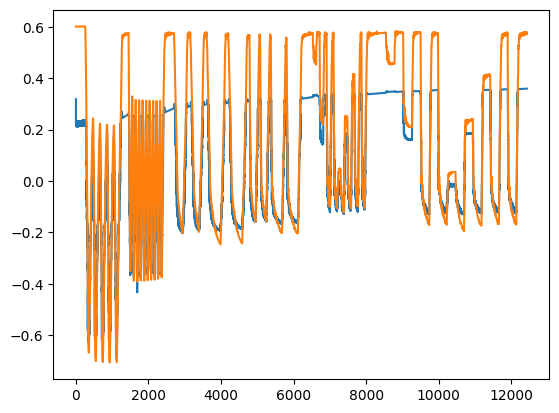

In [116]:
import matplotlib.pyplot as plt
with pd.HDFStore("/content/drive/MyDrive/colab_data/h5_datasets/predictions_v2.h5") as store:
  keys = store.keys()
  key = keys[0]
  df = store.get(key)
  print(key)
  plt.plot(df["model_L2"])
  plt.plot(df["ground_truth"])
  plt.show()